In [1]:
%cd ..

/home/denis/code/ML_model_implementation


/home/denis/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Лабораторная работа №1 (Проведение исследований с алгоритмом Regression)

In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, max_error
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from phik.report import plot_correlation_matrix
pd.set_option('display.max_columns', None)

## Часть 1: Выбор начальных условий

### Набор данных для классификации

In [3]:
data = pd.read_csv("./data/insurance.csv")

In [4]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Описание фичей:

- age: возраст основного бенефициара
- sex: страховой агент пол, женщина, мужчина
- bmi: индекс массы тела, дающий представление о телосложении, весе, который относительно высок или низок по отношению к росту, 
объективный индекс массы тела (кг / м2) с использованием отношения роста к весу, в идеале от 18,5 до 24,9
- children: Количество детей, охваченных медицинской страховкой / Количество иждивенцев
- smoker: Курящий
- region: район проживания получателя в США, северо-восток, юго-восток, юго-запад, северо-запад.
- charges: Индивидуальные медицинские расходы, оплачиваемые медицинской страховкой

#### Разобьем на категориальные и числовые колонки

In [5]:
# Категориальные колонки
categorical_columns = [
    'sex', 'smoker', 'region'
]

# Колонка-таргет
target_columns = 'charges'

# Числовые колонки
numerical_columns = data.columns[~data.columns.isin(categorical_columns + [target_columns])].tolist()

Превратим object в числовые значения и укажем явно, что это категориальный тип данных

In [6]:
label_encoder = {"sex": LabelEncoder(), "smoker": LabelEncoder(), "region": OneHotEncoder()}
data["sex"] = label_encoder["sex"].fit_transform(data["sex"])
data["smoker"] = label_encoder["smoker"].fit_transform(data["smoker"])

region_encoded = label_encoder["region"].fit_transform(data[["region"]])
region_encoded_df = pd.DataFrame(
    region_encoded.toarray(), 
    columns=label_encoder["region"].get_feature_names_out(["region"]),
    index=data.index
)

data = pd.concat([data, region_encoded_df], axis=1)
data = data.drop(columns=["region"])
categorical_columns = region_encoded_df.columns.tolist() + ['sex', 'smoker']

In [7]:
data[categorical_columns] = data[categorical_columns].astype('category')

Разобьем выборку на трэин и валидацию

In [8]:
train, valid = train_test_split(data, train_size=0.8, random_state=42, shuffle=True)

In [9]:
X_train = train.drop(columns=target_columns, inplace=False)
y_train = train[target_columns]

X_valid = valid.drop(columns=target_columns, inplace=False)
y_valid = valid[target_columns]

- В качестве датасета для регрессии я взял страхование
- Таргет - charges
- В качестве метрики качества буду использовать MAE, MAPE, R квадрат и max error, тк они просты для понимания

## Часть 2: Создание бейзлайна и оценка качества

### A: Обучение модели

Для начала сделаем препроцессор и закинем его вместе с pipeline в модель

In [10]:
model = DecisionTreeRegressor()

Обучаем модель

In [11]:
model.fit(X_train, y_train)

DecisionTreeRegressor()

Делаем предсказания по тренировочной выборке и валидационной

In [12]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)

### B: Оценка качества модели

In [13]:
# Расчет метрик для тренировочных предсказаний
train_mae = mean_absolute_error(y_train, train_predict)
train_mape = mean_absolute_percentage_error(y_train, train_predict) * 100  # Преобразуем в проценты
train_r2 = r2_score(y_train, train_predict)
train_max_error = max_error(y_train, train_predict)

# Расчет метрик для валидационных предсказаний
valid_mae = mean_absolute_error(y_valid, valid_predict)
valid_mape = mean_absolute_percentage_error(y_valid, valid_predict) * 100  # Преобразуем в проценты
valid_r2 = r2_score(y_valid, valid_predict)
valid_max_error = max_error(y_valid, valid_predict)

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['MAE', 'MAPE (%)', 'R²', 'Max Error'],
    'Тренировочная выборка': [train_mae, train_mape, train_r2, train_max_error],
    'Валидационная выборка': [valid_mae, valid_mape, valid_r2, valid_max_error]
})

In [14]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,MAE,29.572515,2876.308855
1,MAPE (%),0.847155,35.664222
2,R²,0.998308,0.760304
3,Max Error,9570.687425,22439.121820


Как видим, качество модели не самое лучшее без предобработки, ее стоит дорабатывать

## Улучшение бейзлайна

### EDA

In [15]:
train.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
560,46,0,19.95,2,0,9193.83850,0.0,1.0,0.0,0.0
1285,47,0,24.32,0,0,8534.67180,1.0,0.0,0.0,0.0
1142,52,0,24.86,0,0,27117.99378,0.0,0.0,1.0,0.0
969,39,0,34.32,5,0,8596.82780,0.0,0.0,1.0,0.0
486,54,0,21.47,3,0,12475.35130,0.0,1.0,0.0,0.0


#### Определим кол-во пустых значений в каждой фиче

In [16]:
data.isna().sum()

age                 0
sex                 0
bmi                 0
children            0
smoker              0
charges             0
region_northeast    0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64

Пустых значений нет

### Проверим на выбросы Gender и посмотрим кол-во каждых значений

In [17]:
train.nunique()

age                   47
sex                    2
bmi                  494
children               6
smoker                 2
charges             1070
region_northeast       2
region_northwest       2
region_southeast       2
region_southwest       2
dtype: int64

В Gender нет выбросов

### Выведем основные характеристики фичей

In [18]:
numeric_stats = train.select_dtypes(include=['number']).describe()
categorical_stats = train.select_dtypes(include=['category', 'object']).describe()

In [19]:
numeric_stats

,age,bmi,children,charges
count,1070.000000,1070.000000,1070.000000,1070.000000
mean,39.357009,30.560397,1.107477,13346.089736
std,14.073960,6.043386,1.215983,12019.510778
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.205000,0.000000,4897.667387
50%,39.500000,30.210000,1.000000,9575.442100
75%,51.000000,34.496250,2.000000,16746.657400
max,64.000000,53.130000,5.000000,62592.873090


In [20]:
categorical_stats

,sex,smoker,region_northeast,region_northwest,region_southeast,region_southwest
count,1070,1070,1070.0,1070.0,1070.0,1070.0
unique,2,2,2.0,2.0,2.0,2.0
top,1,0,0.0,0.0,0.0,0.0
freq,548,850,803.0,814.0,787.0,806.0


#### Кол-во дубликатов

In [21]:
sum(train.duplicated())

0

Дубликатов нет

### Визуализируем данные

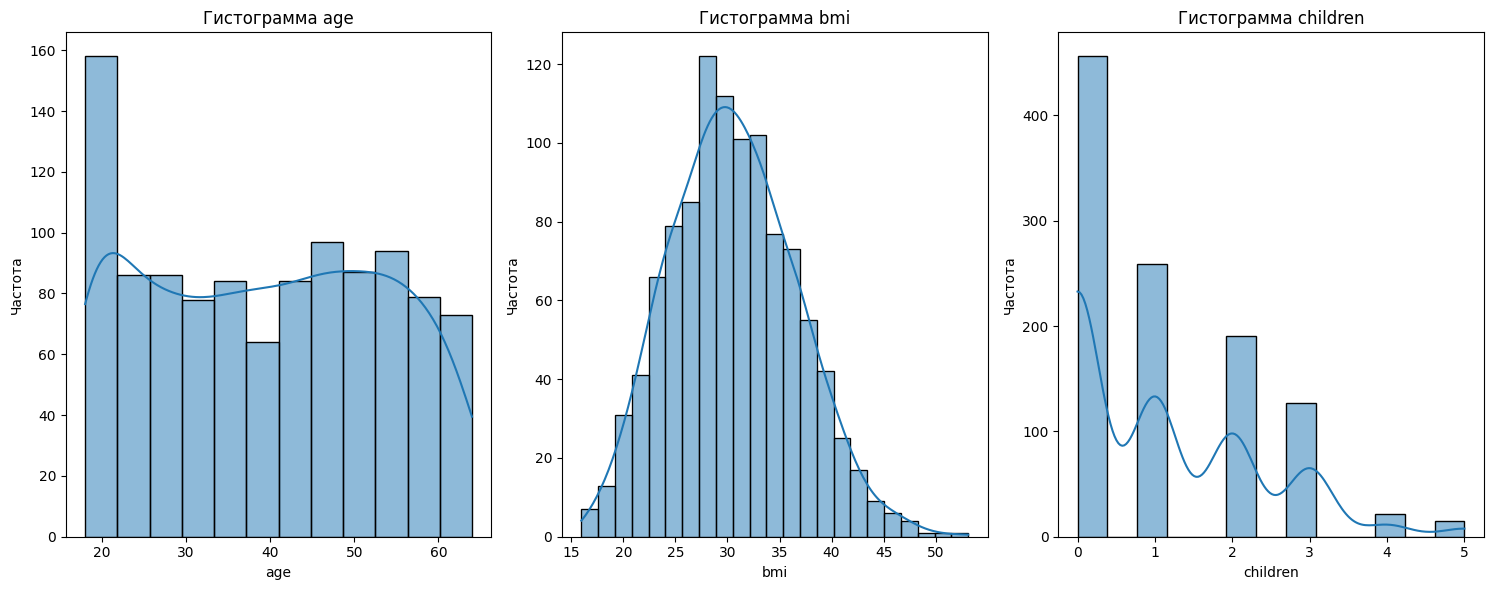

In [22]:
n_cols = 4
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))
axes = axes.flatten()

for idx, col in enumerate(numerical_columns):
    sns.histplot(train[col], kde=True, ax=axes[idx])
    axes[idx].set_title(f'Гистограмма {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Частота')

for i in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

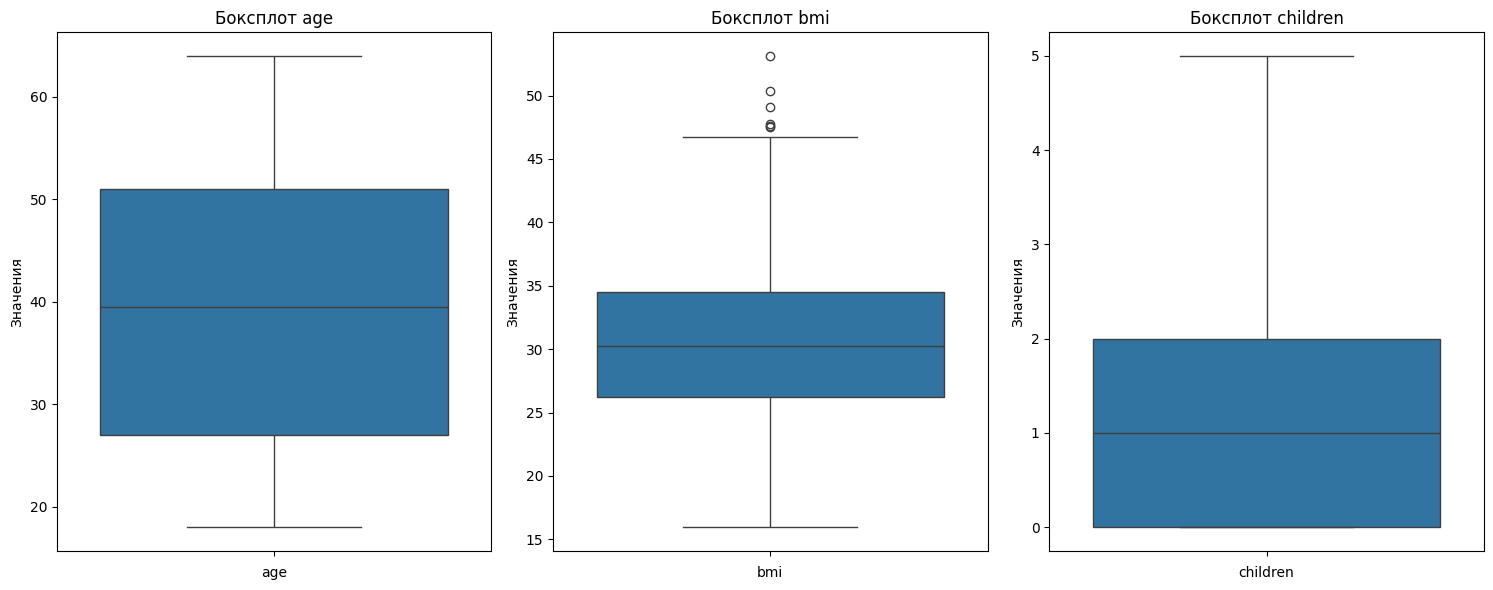

In [23]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))
axes = axes.flatten()

for idx, col in enumerate(numerical_columns):
    sns.boxplot(y=train[col], ax=axes[idx])
    axes[idx].set_title(f'Боксплот {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Значения')

for i in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

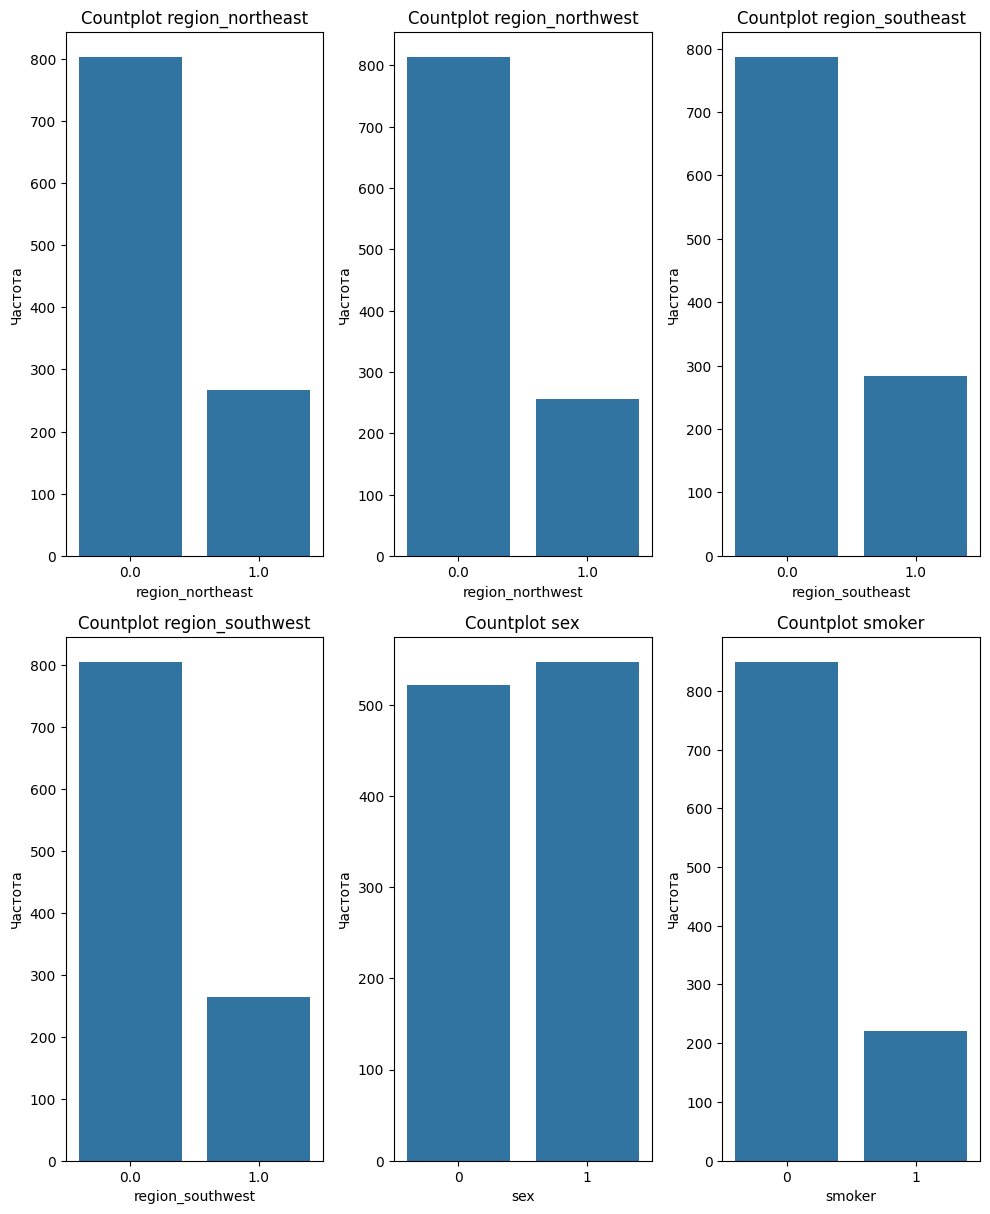

In [24]:
fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=3, figsize=(10, 6 * len(categorical_columns)))
axes = axes.flatten()

for idx, col in enumerate(categorical_columns):
    sns.countplot(x=train[col], ax=axes[idx])
    axes[idx].set_title(f'Countplot {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Частота')

for i in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

/home/denis/.local/lib/python3.10/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable charges is large: 1070. Are you sure this is not an interval variable? Analysis for pairs of variables including charges can be slow.
  warnings.warn(


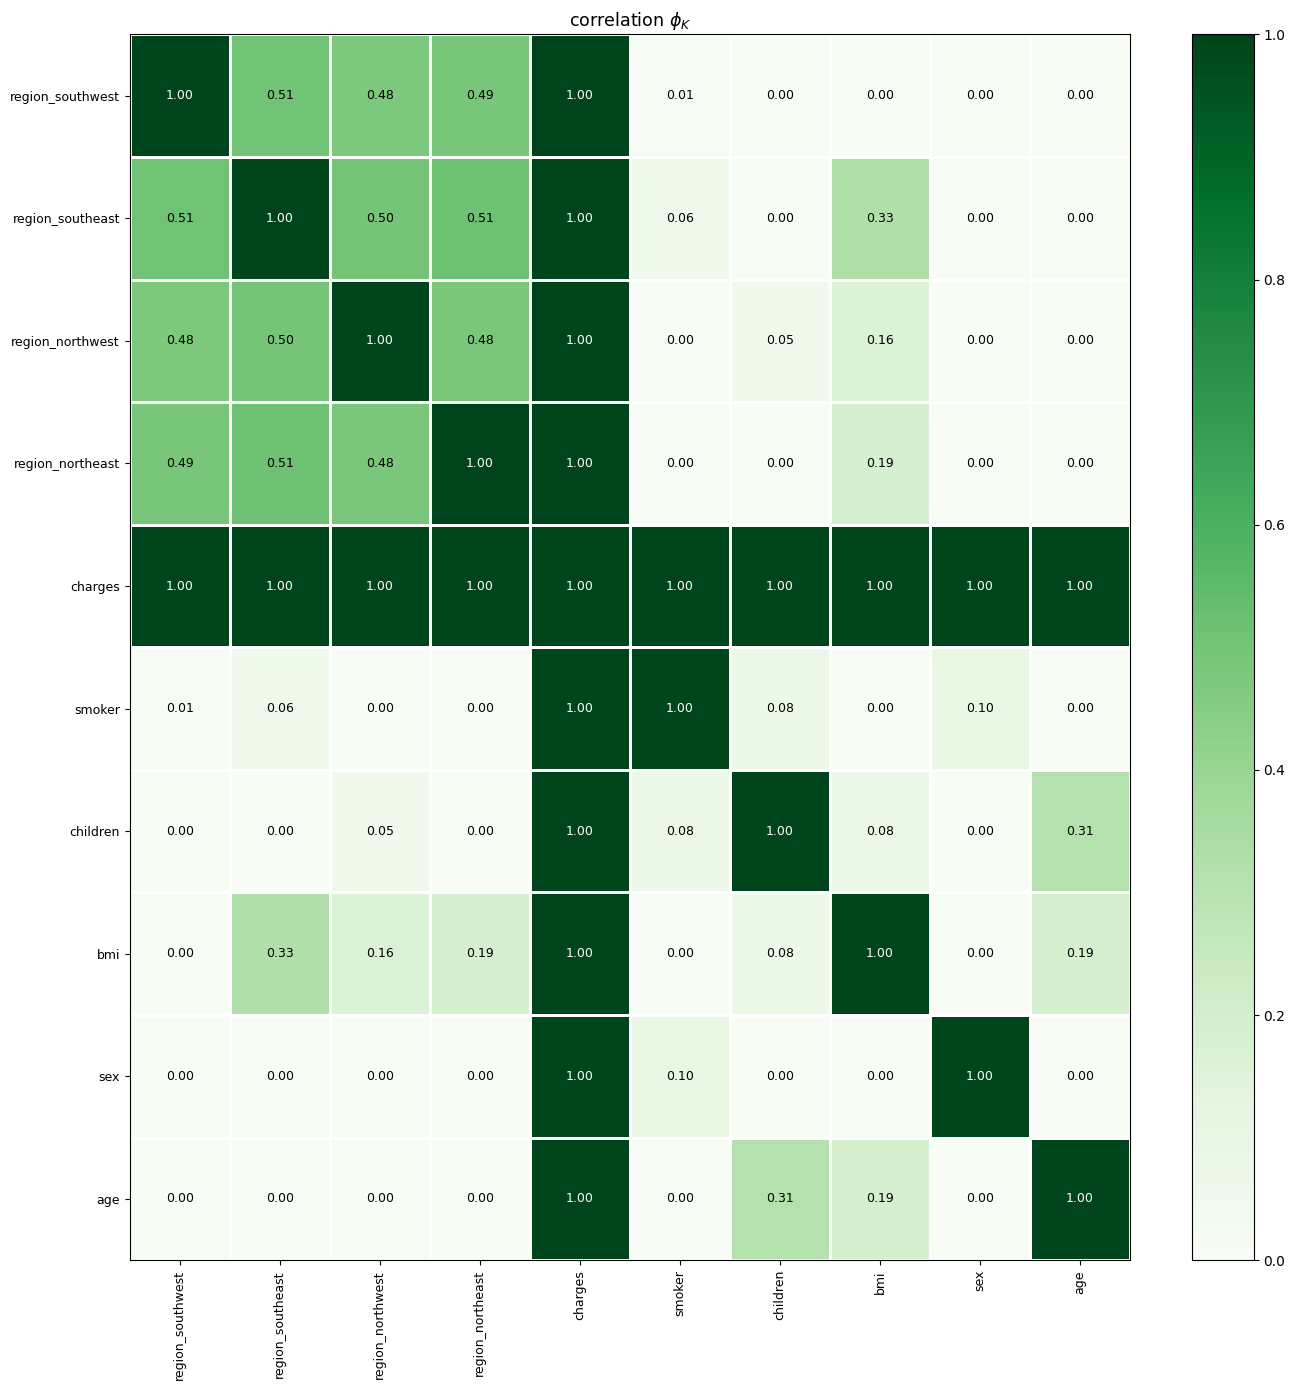

In [25]:
#3. Построение матрицы корреляции признаков
phik_overview = train.phik_matrix(interval_cols=numerical_columns)
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.9, figsize=(14, 14))
plt.tight_layout()

In [26]:
train.corr()

/tmp/ipykernel_36513/2189804198.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()


,age,bmi,children,charges
age,1.000000,0.118274,0.060999,0.281721
bmi,0.118274,1.000000,-0.005040,0.197316
children,0.060999,-0.005040,1.000000,0.071885
charges,0.281721,0.197316,0.071885,1.000000


### Вывод:
- Выбросы в BMI играют важную роль, поэтому их не стоит удалять.
- как видим, charges имеют высокую нелинейную корреляцию с возрастом
- высокая корреляция у признаков между собой, поэтому избавимся от нее

### Избавимся от корреляции

In [27]:
new_X_train = X_train
new_y_train = y_train
new_X_valid = X_valid
new_y_valid = y_valid

In [28]:
pca = PCA(n_components=len(X_train.columns)-1)
scaler = StandardScaler()
pca.fit(scaler.fit_transform(new_X_train))

PCA(n_components=8)

In [29]:
pca.explained_variance_ratio_

array([0.17094786, 0.14980339, 0.14714659, 0.12190137, 0.11842104,
       0.1066841 , 0.10015885, 0.08493679])

Как видим, все колонки нужны, потому их оставим

### Обучаем на новых данных

Также добавим нормировку, чтобы выбросы сильно не влияли на результаты

In [30]:
model = Pipeline((
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=8)),
    ("model", DecisionTreeRegressor())
))

In [31]:
model.fit(new_X_train, new_y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=8)),
                ('model', DecisionTreeRegressor())])

Делаем предсказания по тренировочной выборке и валидационной

In [32]:
train_predict = model.predict(new_X_train)
valid_predict = model.predict(new_X_valid)

### B: Оценка качества модели

In [33]:
# Расчет метрик для тренировочных предсказаний
train_mae = mean_absolute_error(y_train, train_predict)
train_mape = mean_absolute_percentage_error(y_train, train_predict) * 100  # Преобразуем в проценты
train_r2 = r2_score(y_train, train_predict)
train_max_error = max_error(y_train, train_predict)

# Расчет метрик для валидационных предсказаний
valid_mae = mean_absolute_error(y_valid, valid_predict)
valid_mape = mean_absolute_percentage_error(y_valid, valid_predict) * 100  # Преобразуем в проценты
valid_r2 = r2_score(y_valid, valid_predict)
valid_max_error = max_error(y_valid, valid_predict)

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['MAE', 'MAPE (%)', 'R²', 'Max Error'],
    'Тренировочная выборка': [train_mae, train_mape, train_r2, train_max_error],
    'Валидационная выборка': [valid_mae, valid_mape, valid_r2, valid_max_error]
})

In [34]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,MAE,29.572515,4082.274074
1,MAPE (%),0.847155,43.329655
2,R²,0.998308,0.603234
3,Max Error,9570.687425,36364.496000


Как видим, результат не сильно изменился, немного улучшился

## Импортируем собственную реализацию модели ближайших соседей

In [35]:
from implementation import DecisionTreeRegressor

### Обучаем модель

In [36]:
model = DecisionTreeRegressor()

In [37]:
model.fit(X_train, y_train)

Делаем предсказания по тренировочной выборке и валидационной

In [38]:
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)

### B: Оценка качества модели

In [39]:
# Расчет метрик для тренировочных предсказаний
train_mae = mean_absolute_error(y_train, train_predict)
train_mape = mean_absolute_percentage_error(y_train, train_predict) * 100  # Преобразуем в проценты
train_r2 = r2_score(y_train, train_predict)
train_max_error = max_error(y_train, train_predict)

# Расчет метрик для валидационных предсказаний
valid_mae = mean_absolute_error(y_valid, valid_predict)
valid_mape = mean_absolute_percentage_error(y_valid, valid_predict) * 100  # Преобразуем в проценты
valid_r2 = r2_score(y_valid, valid_predict)
valid_max_error = max_error(y_valid, valid_predict)

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['MAE', 'MAPE (%)', 'R²', 'Max Error'],
    'Тренировочная выборка': [train_mae, train_mape, train_r2, train_max_error],
    'Валидационная выборка': [valid_mae, valid_mape, valid_r2, valid_max_error]
})

In [40]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,MAE,934.413663,3177.859716
1,MAPE (%),11.390936,36.630150
2,R²,0.964321,0.743219
3,Max Error,16505.470610,21895.734990


### Обучаем с улучшенным бейзлайном

In [62]:
model = Pipeline((
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=8)),
    ("model", DecisionTreeRegressor(min_leaf_split=40, max_depth=5))
))

In [63]:
model.fit(new_X_train, new_y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=8)),
                ('model',
                 <implementation.DecTree.DecisionTreeRegressor object at 0x734fc93bc100>)])

Делаем предсказания по тренировочной выборке и валидационной

In [64]:
train_predict = model.predict(new_X_train)
valid_predict = model.predict(new_X_valid)

### B: Оценка качества модели

In [65]:
# Расчет метрик для тренировочных предсказаний
train_mae = mean_absolute_error(y_train, train_predict)
train_mape = mean_absolute_percentage_error(y_train, train_predict) * 100  # Преобразуем в проценты
train_r2 = r2_score(y_train, train_predict)
train_max_error = max_error(y_train, train_predict)

# Расчет метрик для валидационных предсказаний
valid_mae = mean_absolute_error(y_valid, valid_predict)
valid_mape = mean_absolute_percentage_error(y_valid, valid_predict) * 100  # Преобразуем в проценты
valid_r2 = r2_score(y_valid, valid_predict)
valid_max_error = max_error(y_valid, valid_predict)

# Сводка метрик в таблицу для удобного отображения
metrics_df = pd.DataFrame({
    'Метрика': ['MAE', 'MAPE (%)', 'R²', 'Max Error'],
    'Тренировочная выборка': [train_mae, train_mape, train_r2, train_max_error],
    'Валидационная выборка': [valid_mae, valid_mape, valid_r2, valid_max_error]
})

In [66]:
metrics_df.head()

,Метрика,Тренировочная выборка,Валидационная выборка
0,MAE,3372.276780,4279.550290
1,MAPE (%),36.725093,46.803176
2,R²,0.806054,0.675751
3,Max Error,29349.239950,32694.870000


## Вывод:
Как видим, модель, написанная мною работает аналогично модели sklearn, что очень радует!  
Также, отмечу, что при eda модель показала себя хуже, возможно из-за удаления какой-то фичи (возможно не следовало удалять все фичи, тк дерево сам по себе хорошо отбирает признаки).